# Import

In [1]:
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.patheffects as PathEffects

In [2]:
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate,Embedding,Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy
import os
import pickle
import matplotlib.pyplot as plt

In [3]:
from itertools import permutations
import seaborn as sns
from keras.datasets import mnist
from sklearn.manifold import TSNE
from sklearn.svm import SVC

# Load Data

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalization
x_train = x_train / 255
x_test = x_test / 255

print()

print('x_train shape : {}'.format(x_train.shape))
print('x_test shape : {}'.format(x_test.shape))



x_train shape : (60000, 28, 28)
x_test shape : (10000, 28, 28)


# Dataset Embbeding Visualize

In [5]:
# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [6]:
x_train_flat = x_train.reshape(-1,784)
x_test_flat = x_test.reshape(-1,784)
x_test_flat.shape, x_train_flat.shape

((10000, 784), (60000, 784))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


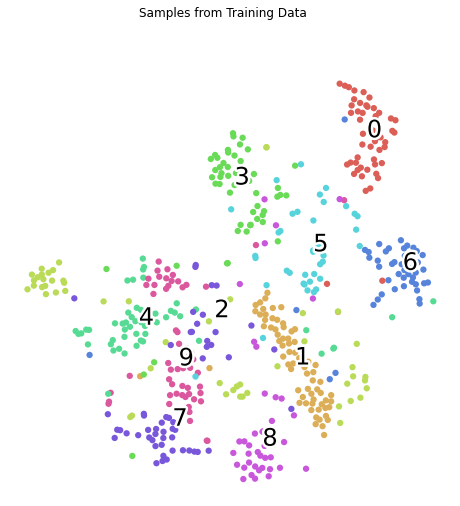

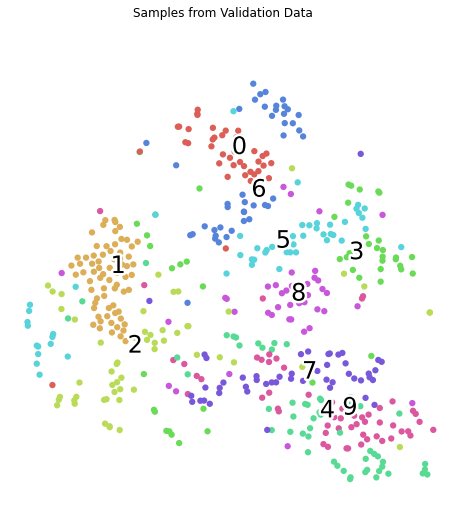

In [7]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
scatter(train_tsne_embeds, y_train[:512], "Samples from Training Data")

eval_tsne_embeds = tsne.fit_transform(x_test_flat[:512])
scatter(eval_tsne_embeds, y_test[:512], "Samples from Validation Data")

# Generate Tripplet

In [8]:
def generate_triplet(x,y,testsize=0.3,ap_pairs=10,an_pairs=10):
    data_xy = tuple([x,y])

    trainsize = 1-testsize

    triplet_train_pairs = []
    triplet_test_pairs = []
    for data_class in sorted(set(data_xy[1])):

        same_class_idx = np.where((data_xy[1] == data_class))[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        

        #train
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_train_pairs.append([Anchor,Positive,Negative])               
        #test
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_test_pairs.append([Anchor,Positive,Negative])    
                
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [9]:
X_train, X_test = generate_triplet(x_train_flat,y_train, ap_pairs=150, an_pairs=150,testsize=0.2)
X_train.shape, X_test.shape


((180000, 3, 784), (45000, 3, 784))

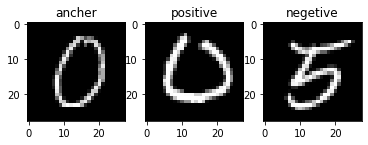

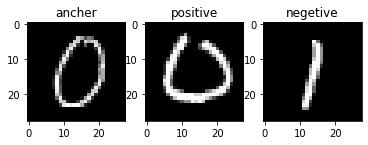

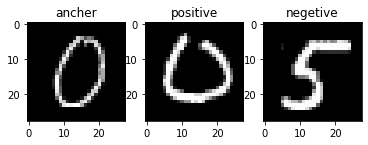

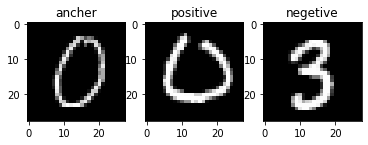

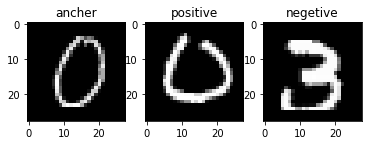

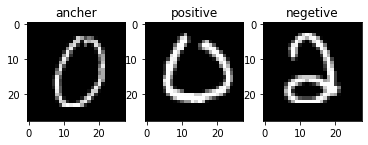

In [10]:
import copy

x=copy.deepcopy(X_train[100:106])
for i in range(len(x)):
    fig, ax =plt.subplots(1, 3)
    ax[0].imshow(x[i][0].reshape((28, 28)), cmap='gray')
    ax[0].set_title('ancher')
    ax[1].imshow(x[i][1].reshape((28, 28)), cmap='gray')
    ax[1].set_title('positive')
    ax[2].imshow(x[i][2].reshape((28, 28)), cmap='gray')
    ax[2].set_title('negetive')


reshape the X_train & X_test for training the model.

In [11]:
def reshaping(x, size):
    x = x.transpose(1, 0 ,2).reshape((3, size, 28, 28))
    return [x[0], x[1], x[2]]

X_train = reshaping(X_train, 180000)
X_test = reshaping(X_test, 45000)

print(f'len of x_train : {len(X_train)}')
print(f'shape of x_train : {X_train[0].shape}')
print()
print(f'len of x_test : {len(X_test)}')
print(f'shape of x_test : {X_test[0].shape}')


len of x_train : 3
shape of x_train : (180000, 28, 28)

len of x_test : 3
shape of x_test : (45000, 28, 28)


# Tripplet Loss

In [12]:
def triplet_loss(y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    loss = 0

    anchor = y_pred[0]
    positive = y_pred[1]
    negative = y_pred[2]
    distance_anchor_positive = K.sum(K.square(anchor-positive),axis=1)
    distance_anchor_negetive = K.sum(K.square(anchor-negative),axis=1)
    loss = K.maximum(distance_anchor_positive - distance_anchor_negetive + alpha, loss)
    return loss

def average_loss(y_true, y_pred):
    return K.mean(y_pred)

# Embedding Predictions Network

In [13]:
def embedding_pred_net(dim):
    """
    embedding predictions: Base network to be shared
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(10))
    model.summary()
    return model

# Siamese Network

In [14]:
anchor_in = Input((28,28,1, ), name='input-anchor')
positive_in = Input((28,28,1, ), name='input-positive')
negative_in = Input((28,28,1, ), name='input-negative')

# Shared embedding layer for positive and negative items
embedding_net = embedding_pred_net((28,28,1,))

anchor_embedding = embedding_net(anchor_in)
positive_embedding = embedding_net(positive_in)
negative_embedding = embedding_net(negative_in)

merged_vector = Lambda(triplet_loss)([anchor_embedding, positive_embedding, negative_embedding])

model = Model(inputs=[anchor_in,positive_in, negative_in], outputs=merged_vector)

adam_optim = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(loss=average_loss, optimizer=adam_optim)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 64)                147520    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

# Training

In [15]:
"""
Write your code here ...
"""
history = model.fit(X_train, np.zeros(X_train[0].shape[0]),validation_data=[X_test, np.zeros(X_test[0].shape[0])], batch_size=256, epochs=10)

Epoch 1/10
704/704 [==============================] - 47s 54ms/step - loss: 0.0798 - val_loss: 0.0341
Epoch 2/10
704/704 [==============================] - 38s 53ms/step - loss: 0.0175 - val_loss: 0.0238
Epoch 3/10
704/704 [==============================] - 35s 50ms/step - loss: 0.0089 - val_loss: 0.0193
Epoch 4/10
704/704 [==============================] - 37s 53ms/step - loss: 0.0056 - val_loss: 0.0190
Epoch 5/10
704/704 [==============================] - 37s 53ms/step - loss: 0.0039 - val_loss: 0.0197
Epoch 6/10
704/704 [==============================] - 38s 53ms/step - loss: 0.0032 - val_loss: 0.0231
Epoch 7/10
704/704 [==============================] - 35s 50ms/step - loss: 0.0026 - val_loss: 0.0230
Epoch 8/10
704/704 [==============================] - 38s 53ms/step - loss: 0.0021 - val_loss: 0.0246
Epoch 9/10
704/704 [==============================] - 38s 54ms/step - loss: 0.0018 - val_loss: 0.0229
Epoch 10/10
704/704 [==============================] - 37s 53ms/step - loss: 0.001

# Visualize Data Using t-SNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


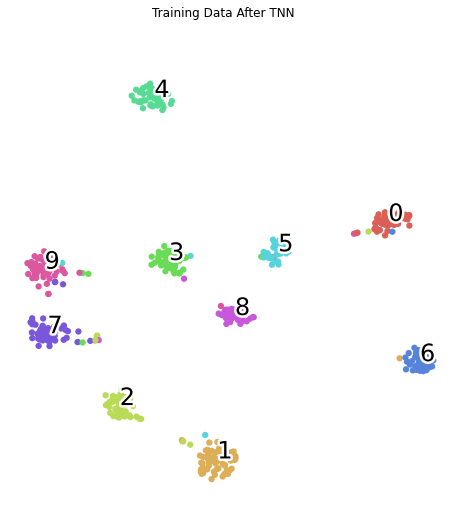

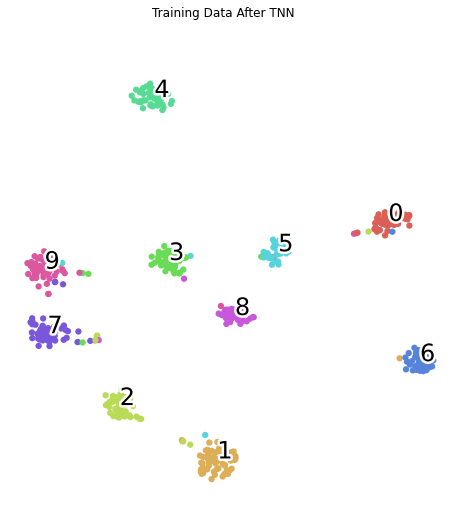

In [16]:
trained_model = Model(inputs=anchor_in, outputs=anchor_embedding)


tsne = TSNE()
X_train_trm = trained_model.predict(x_train[:512])
X_test_trm = trained_model.predict(x_test[:512])
train_tsne_embeds = tsne.fit_transform(X_train_trm)
eval_tsne_embeds = tsne.fit_transform(X_test_trm)
scatter(train_tsne_embeds, y_train[:512], "Training Data After TNN")
scatter(train_tsne_embeds, y_train[:512], "Training Data After TNN")